# 01. Map polynya events with University Bremen ASI Sea Ice Concentrations

Data source:
https://seaice.uni-bremen.de/sea-ice-concentration/amsre-amsr2/

**This version of the map is edited by Noel Wang, based on the original code by Mackenzie Jewell**

This version is in the fork.

Note: the date ranges of this file are from 

June 6 2002 to 7 29 2002 <br>
8-08-2002- Oct 4 2011 <br>
July 7 2012 to june 13 2024 <br>

Note: to specify the version of Python used by the AK_polynya environment, edit the environment.yml file python ==version

## Import packages

In [71]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider #import packages for the slider
import matplotlib.animation as animation #imported for animation
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

#import shapely
import shapely
from shapely import Polygon, geometry
from shapely.geometry import Point

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the date range

In [72]:
#making the date list
#============================
date_list = pd.date_range(datetime(2024, 1, 12), datetime(2024, 1, 12)) #make this a date list

#============================

print(len(date_list))

1


## Grab data, SIC concentration

In [65]:
#making the date list
#============================
date_list = date_list

#============================

#olddatarange
d1 = (850, 950) #along y
d2 = (200, 325) #along x

#list of SIC Concentrations
SIC_list = []

for date in date_list:
    # if date > datetime(2011, 10, 4) and date < datetime(2012, 7, 2):
    #     continue      
    # else:
        # read daily sic data from computer files into dictionary
        data = grab_ASI_SIC(date=date.to_pydatetime(), 
            main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
            coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
            hemisphere='n', resolution='6250', version='v5.4', 
            return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
            include_units=False, annual_folders=False, return_dict = True, quiet=True)
        
        # datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
        datarange = data['sic'][mask2]
        average_SIC = (np.nanmean(datarange))
        SIC_list.append(average_SIC)

print(len(SIC_list))


1


## Make map

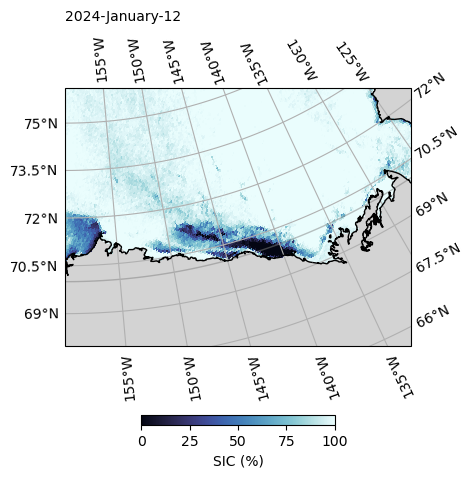

In [6]:
for date in date_list:
    # if datetime(2011, 10, 4) <= date <= datetime(2012, 7, 2):
    #     continue
    
# if date.month == 1 and date.day > 15:
    # read daily sic data from computer files into dictionary
    data = grab_ASI_SIC(date=date.to_pydatetime(), 
                    main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                    hemisphere='n', resolution='6250', version='v5.4', 
                    return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                    include_units=False, annual_folders=False, return_dict = True, quiet=True)


    # create figure
    #--------------
    # create map figure in north polar stereographic projection
    map_projection = ccrs.NorthPolarStereo(central_longitude=200) #rotation of the map
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection=map_projection))

    # background color
    ax.patch.set_facecolor('lightgray')

    # set map extent [lon1, lon2, lat1, lat2]
    ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

    # add coastlines
    ax.coastlines(zorder=100)

    # lat / lon lines
    add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)
    ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)


    # plot 2d sic data (all)
    icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                        cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])
    
    #datarange
    d1 = (880, 950) #along y (right side, left side)
    d2 = (240, 325) #along x (bottom, top)

    # # plot 2d sic data (limited)
    # icec = ax.pcolormesh(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], data['sic'][d1[0]:d1[1], d2[0]:d2[1]], 
    #                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

    # visualize the data points        
    sp =10
    # ax1.scatter(data['xx'][::sp, ::sp], data['yy'][::sp, ::sp], transform=data['proj'])
    
    #add colorbar
    plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.18)

    # label date
    ax.text(0, 1.25, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)
    
    # ax.scatter(1653125.0,-3315625.0, transform = data['proj'], zorder = 100, s=100)
    # ax.scatter(-135, 72, transform=ccrs.PlateCarree())

    # #save figure, if desired
    # save_path = f'/Users/reu/Box/Maps/SIC_maps/Jan2004/cropped_map_{date.strftime("%Y-%m-%d")}.png'
    # fig.savefig(save_path, dpi=300, bbox_inches = 'tight')
    # # maps_list.append(save_path)
    
    plt.show()


In [16]:
print(data['xx'][325, 880])

    # d1 = (880, 950) #along y (right side, left side)
    # d2 = (240, 325) #along x (bottom, top)

1653125.0


## SIC time series plot

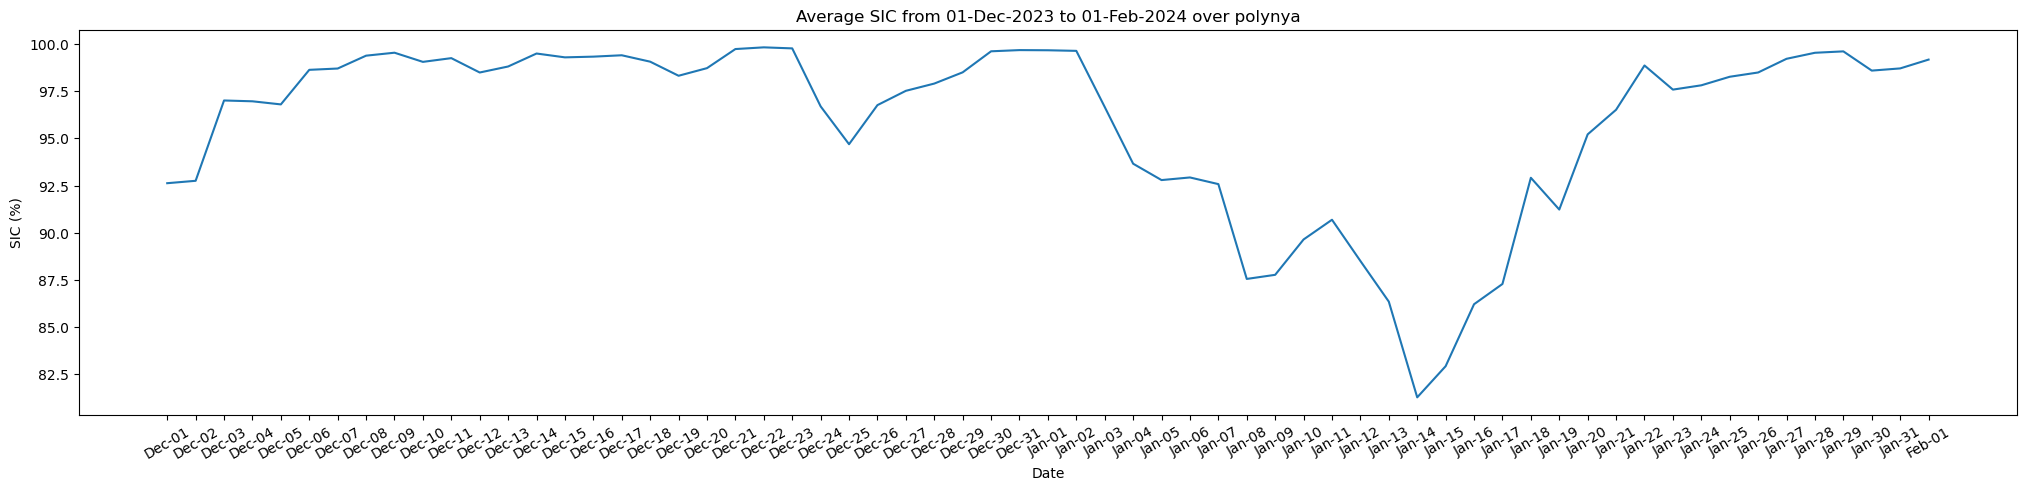

In [21]:
# Creating the plot
x = date_list
y = SIC_list
fig2, ax2 = plt.subplots(figsize=(25,5))
plt.plot(x,y)

# Adding a title
plt.title(f'Average SIC from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")} over polynya')

# Adding and customizing axis labels
plt.xlabel('Date')
plt.ylabel('SIC (%)')
plt.xticks(rotation=30)
plt.xticks(date_list)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d')) 

# ax2.axvspan(datetime(2013, 12,28), datetime(2014, 1, 2), facecolor='lightgray', alpha=0.2)


plt.show()

## area and extent calculation, CSV Export

In [66]:
##polynya area

grid_size = 39.0625
SIC_grid = (data['sic'][mask2])
openwater_area_grid = (1-(SIC_grid/100)) * (grid_size) #measures area of open water in each grid cell
openwater_area = np.nansum(openwater_area_grid)

print(openwater_area)
# np.nanmax(SI_area_grid)

##polynya extent (<15% ice concentration as the threshold)

grid_size = 39.0625
openwater_extent_array = (1-(SIC_grid[SIC_grid < 15]/100)) * (grid_size) #measures extent of open water
openwater_extent = np.nansum(openwater_extent_array)
print(openwater_extent)


#turning into lists
grid_size = 39.0625 #km^2
openwater_areas_list = []
openwater_extents_list = []

for date in date_list:
    if date > datetime(2011, 10, 4) and date < datetime(2012, 7, 2):
        continue
        
    else:
        # read daily sic data from computer files into dictionary
        data = grab_ASI_SIC(date=date.to_pydatetime(), 
                        main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                        coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                        hemisphere='n', resolution='6250', version='v5.4', 
                        return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                        include_units=False, annual_folders=False, return_dict = True, quiet=True)

        SIC_grid = (data['sic'][mask2])
        openwater_area_grid = (1-(SIC_grid/100)) * (grid_size) #measures area of open water in each grid cell
        openwater_area = np.nansum(openwater_area_grid)
        openwater_areas_list.append(openwater_area)
        
        openwater_extent_array = (1-(SIC_grid[SIC_grid < 15]/100)) * (grid_size) #measures extent of open water
        openwater_extent = np.nansum(openwater_extent_array)
        openwater_extents_list.append(openwater_extent)
        
print(len(openwater_areas_list))
print(len(openwater_extents_list))

# #export csv

# d = {'time': date_list, 'SIC_percent': SIC_list, 'Open_water_area_km2': openwater_areas_list, 'Open_water_extent_km2': openwater_extents_list}
# datafile = pd.DataFrame(data=d)
# datafile.to_csv(f'/Users/reu/Box/Data/{date_list[1].strftime("%b%Y")}_{date_list[-2].strftime("%b%Y")}SIC.csv', index=None) #removes Index column


24530.7
8176.5796
1
1


In [67]:
##polynya area

grid_size = 39.0625
SIC_grid = (data['sic'][mask2])
openwater_area_grid = (1-(SIC_grid/100)) * (grid_size) #measures area of open water in each grid cell
openwater_area = np.nansum(openwater_area_grid)

print(openwater_area)
# np.nanmax(SI_area_grid)

##polynya extent (<15% ice concentration as the threshold)

grid_size = 39.0625
openwater_extent_array = (1-(SIC_grid[SIC_grid < 15]/100)) * (grid_size) #measures extent of open water
openwater_extent = np.nansum(openwater_extent_array)
print(openwater_extent)

print(len(openwater_extents_list))
print(len(openwater_extents_list))
print(len(SIC_list))
print(len(date_list))

24530.7
8176.5796
1
1
1
1


## time series of polynya size 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


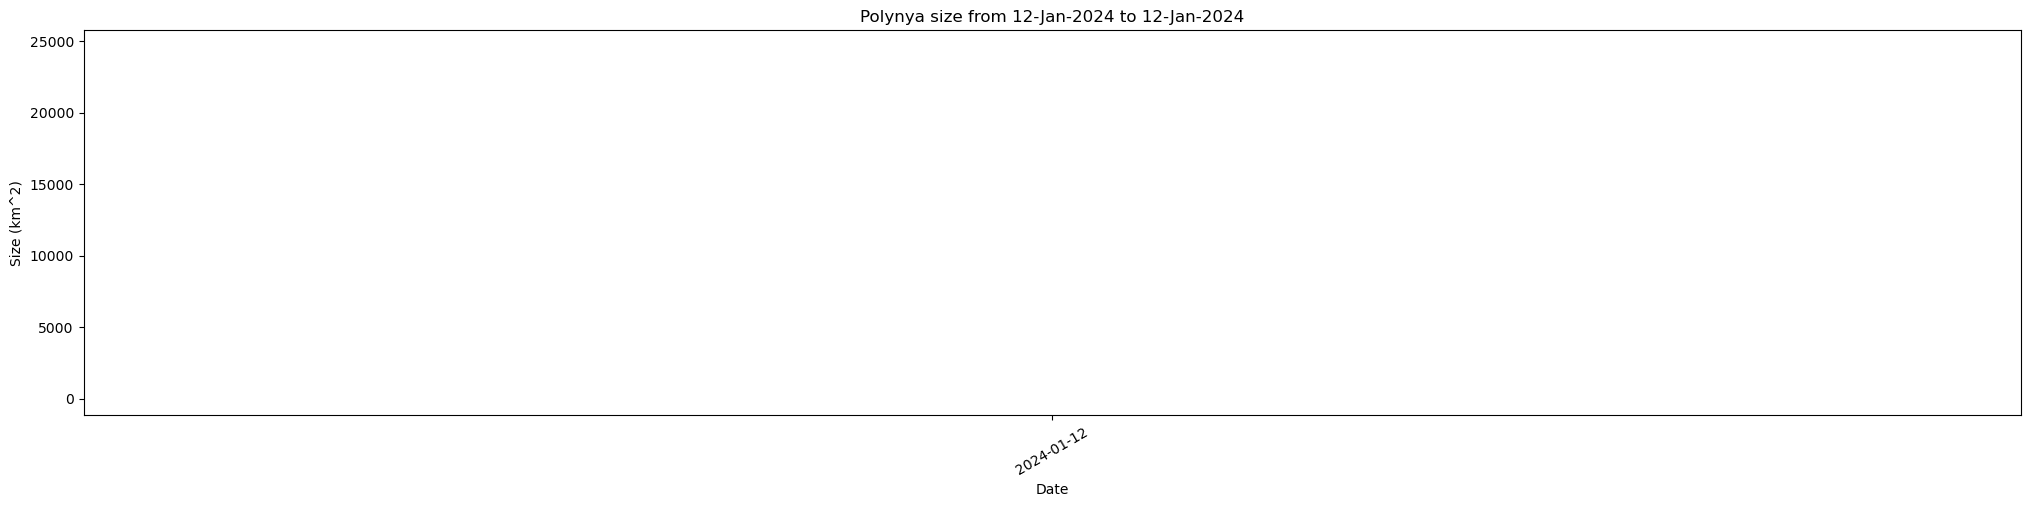

In [68]:
# Creating the plot with scaled axes
fig, ax1 = plt.subplots(figsize=(25,5))
t = date_list
x = openwater_areas_list
y = openwater_extents_list
z = SIC_list


plt.plot(date_list, openwater_areas_list, label='Open water area')
plt.plot(date_list, openwater_extents_list, label = 'Open water extent')
plt.plot(date_list, SIC_list, label = "SIC in percent")

# Adding a title
plt.title(f'Polynya size from {date_list[0].strftime("%d-%b-%Y")} to {date_list[-1].strftime("%d-%b-%Y")}')

# Adding and customizing axis labels
plt.xlabel('Date')
plt.ylabel('Size (km^2)')
plt.xticks(rotation=30)
plt.xticks(date_list)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d')) 
ax.legend()


plt.show()

## Determining points of a polygon

(-1965440.664760321, 1.7336271305461218e-08)


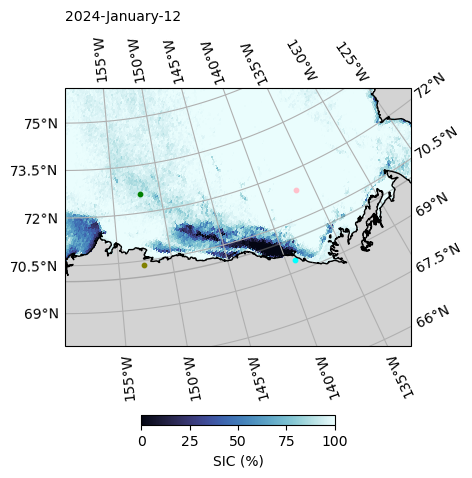

<Figure size 640x480 with 0 Axes>

In [75]:
date_list = pd.date_range(datetime(2024, 1, 12), datetime(2024, 1, 12)) #make this a date list

for date in date_list:
    # if datetime(2011, 10, 4) <= date <= datetime(2012, 7, 2):
    #     continue
    
# if date.month == 1 and date.day > 15:
    # read daily sic data from computer files into dictionary
    data = grab_ASI_SIC(date=date.to_pydatetime(), 
                    main_path='/Volumes/Seagate2/asi-AMSR-SIC/n6250/', 
                    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                    hemisphere='n', resolution='6250', version='v5.4', 
                    return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                    include_units=False, annual_folders=False, return_dict = True, quiet=True)


    # create figure
    #--------------
    # create map figure in north polar stereographic projection
    map_projection = ccrs.NorthPolarStereo(central_longitude=200) #rotation of the map
    fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection=map_projection))

    # background color
    ax.patch.set_facecolor('lightgray')

    # set map extent [lon1, lon2, lat1, lat2]
    ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

    # add coastlines
    ax.coastlines(zorder=100)

    # lat / lon lines
    add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)
    ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)


    # plot 2d sic data (all)
    icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                        cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])
    
    #datarange
    d1 = (880, 950) #along y (right side, left side)
    d2 = (240, 325) #along x (bottom, top)

    # # plot 2d sic data (limited)
    # icec = ax.pcolormesh(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], data['sic'][d1[0]:d1[1], d2[0]:d2[1]], 
    #                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

    # # visualize the data points        
    # sp =10
    # ax.scatter(data['xx'][da[0]:da[1], db[0]:db[1]], data['yy'][da[0]:da[1], db[0]:db[1]], zorder = 100, transform=data['proj'])
    
    #add colorbar
    plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.5, pad=0.18)

    # label date
    ax.text(0, 1.25, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)
    
    # figure out the data value at this point
    print(data['proj'].transform_point(-135, 72, ccrs.PlateCarree()))
    
    # #plotting the first polygon
    # ax.scatter(data['xx'][870, 280], data['yy'][870, 280], s=10, color='red', transform=data['proj'])
    # ax.scatter(data['xx'][800, 320], data['yy'][935, 340], s=10, color='orange', transform=data['proj'])
    # ax.scatter(data['xx'][950, 300], data['yy'][950, 300], s=10, color='brown', transform=data['proj'])
    # ax.scatter(data['xx'][880, 250], data['yy'][880, 250], s=10, color='purple', transform=data['proj'])
    
    #plotting the second polygon
    ax.scatter(data['xx'][865, 290], data['yy'][865, 290], s=10, color='pink', transform=data['proj'])    
    ax.scatter(data['xx'][945, 325], data['yy'][945, 325], s=10, color='green', transform=data['proj'])
    ax.scatter(data['xx'][960, 288], data['yy'][960, 288], s=10, color='olive', transform=data['proj'])
    ax.scatter(data['xx'][882, 255], data['yy'][882, 255], s=10, color='cyan', transform=data['proj'])
    
    # # #test out the polygon!
    # ax.add_geometries([polygon2], crs=data['proj'])
    # ax.scatter(data["xx"][mask2], data["yy"][mask2], transform = data["proj"])
    
    plt.show()
    plt.clf()
    
        #     # #save figure, if desired
    # save_path = f'/Users/reu/Box/cropped_map_{date.strftime("%Y-%m-%d")}.png'
    # fig.savefig(save_path, dpi=300, bbox_inches = 'tight')
    # # maps_list.append(save_path)

[-2096875.0, -1846875.0, -1971875.0, -2284375.0]
[90625.0, 496875.0, 590625.0, 153125.0]
False


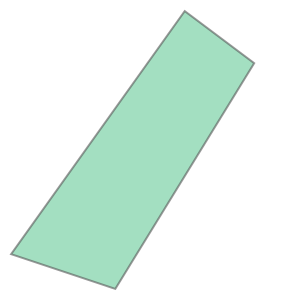

In [56]:
# polygon numbero uno (the smaller polygon for SIC)

listx1 = []
listx1.append(data['xx'][870, 280])
# listx.append(data['yy'][935, 340])
listx1.append(data['xx'][800, 320])
listx1.append(data['xx'][950, 300])
listx1.append(data['xx'][880, 250])


listy1 = []
listy1.append((data['yy'][870, 280]))
listy1.append(data['yy'][935, 340])
# listx.append(data['xx'][800, 320])
listy1.append(data['yy'][950, 300])
listy1.append(data['yy'][880, 250])

print(listx1)
print(listy1)

polygon1 = geometry.Polygon([[x, y] for x,y in zip(listx1, listy1)])

mask1 = np.full(data["xx"].shape, False)

for ii in range (mask1.shape[0]):
    for jj in range (mask1.shape[1]):
        
        point1 = Point(data['xx'][ii,jj], data['yy'][ii, jj])
        mask1[ii, jj] = polygon1.contains(point1)


print(polygon1.contains(point1))
polygon1

[-2034375.0, -1815625.0, -2046875.0, -2253125.0]
[59375.0, 559375.0, 653125.0, 165625.0]
False


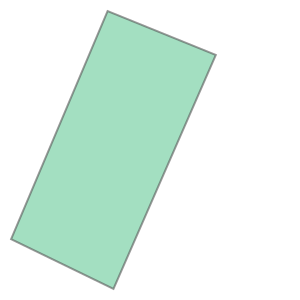

In [70]:
# polygon numbero dos (the larger polygon for SIC)

listx2 = []
listx2.append(data['xx'][865, 290])
listx2.append(data['xx'][945, 325])
listx2.append(data['xx'][960, 288])
listx2.append(data['xx'][882, 255])


listy2 = []
listy2.append(data['yy'][865, 290])
listy2.append(data['yy'][945, 325])
listy2.append(data['yy'][960, 288])
listy2.append(data['yy'][882, 255])

print(listx2)
print(listy2)

polygon2 = geometry.Polygon([[x, y] for x,y in zip(listx2, listy2)])

mask2 = np.full(data["xx"].shape, False)

for ii in range (mask2.shape[0]):
    for jj in range (mask2.shape[1]):
        
        point2 = Point(data['xx'][ii,jj], data['yy'][ii, jj])
        mask2[ii, jj] = polygon2.contains(point2)

d = {'xlist': listx2, 'ylist': listy2}
datafile = pd.DataFrame(data=d)
datafile.to_csv(f'/Users/reu/Box/Data/mask2.csv', index=None) #removes Index column


print(polygon2.contains(point2))
polygon2

In [ ]:
datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
np.nanmean(datarange)

## Creating a cropped map in the original coordinate system

<class 'cartopy.crs.NorthPolarStereo'>


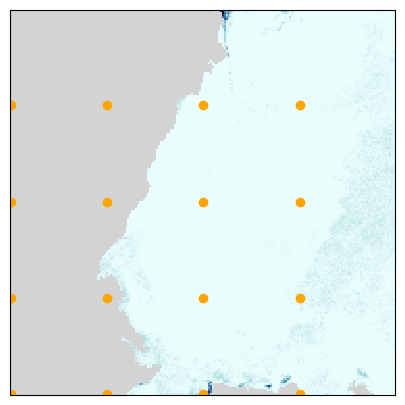

In [20]:
# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = data['proj']
# map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(5,5), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
# ax.set_extent([200, 230, 68, 74], crs=ccrs.PlateCarree())  

#datarange
d1 = (800, 1000) #along y
d2 = (200, 400)

# plot 2d sic data 
icec = ax.pcolormesh(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], data['sic'][d1[0]:d1[1], d2[0]:d2[1]], 
                    cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

# plotting a grid of points
# sp = 50
# ax.scatter(data['xx'][::sp, ::sp], data['yy'][::sp, ::sp], transform=data['proj'])
# # transform tells function original >> map_projection

#highlighting a subset of data 
ax.scatter(data['xx'][d1[0]:d1[1], d2[0]:d2[1]][::sp, ::sp], data['yy'][d1[0]:d1[1], d2[0]:d2[1]][::sp, ::sp], transform=data['proj'], c='orange')

#showing a subset of the data
#data['xx']
#data["ds"].x.values

print(type(data["proj"]))

In [33]:
data['ds']

<xarray.Dataset>
Dimensions:              (x: 1216, y: 1792)
Coordinates:
  * x                    (x) float64 -3.847e+06 -3.841e+06 ... 3.747e+06
  * y                    (y) float64 -5.347e+06 -5.341e+06 ... 5.847e+06
Data variables:
    polar_stereographic  |S1 ...
    z                    (y, x) float32 nan nan nan nan nan ... nan nan nan nan
Attributes:
    author:       University of Bremen, Gunnar Spreen [gunnar.spreen@uni-brem...
    Conventions:  CF-1.5
    GMT_version:  6.3.0 [64-bit]
    history:      Mon Jan 15 05:34:07 2024: GDAL CreateCopy( /mnt/web//data/a...
    info:         AMSR2 sea ice concentration based on the ASI algorithm (Spr...
    title:        Produced by grdmath
    GDAL:         GDAL 3.4.1, released 2021/12/27

## Code Graveyard

In [37]:
#trying to fix axes but I figured it out with xticks

i = 0
newlist = []
while i < 3:
    newlist.append(date_list[i])
    i += 1
print(newlist)

print(type((np.datetime64('2024-01-01'))))
print(type(date_list[0]))

# converted = date.to_pydatetime()(date_list[0])
# print(f'converted is = {type(converted)}')

l = np.arange(np.datetime64('2024-01-01'), np.datetime64('2024-01-31'))

[Timestamp('2003-12-01 00:00:00'), Timestamp('2003-12-02 00:00:00'), Timestamp('2003-12-03 00:00:00')]
<class 'numpy.datetime64'>
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
#a useful line for seeing information about a dataset. This works for 'xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds' 
#data["ds"]
#data['proj']

# data['ds'].x.shape

#data['yy'][d1[0]:d1[1], :]

#example of a graph of all of the data. Not quite sure why it's in Vikings colors though
#plt.pcolormesh(data['xx'], data['yy'], data['sic'])

In [ ]:
#I ended up using MacKenzie's code to make into a GIF

# import imageio
# images = []
# for filename in :
#     images.append(imageio.imread(save_path))
# imageio.mimsave('/path/to/movie.gif', images)

In [ ]:
#date logic

date_list = pd.date_range(datetime(2003, 1, 1), datetime(2024, 1, 31)) #make this a date list

for date in date_list:
    if date.year ==  2004 or (date.year == 2014) or (date.year == 2024):
        if date.month == 1:
            print(date)
    elif date.year == 2003 or (date.year == 2013):
        if date.month == 12 and date.day > 19:
            print(date)
    else:
        continue

In [ ]:
# vertical slider??
# 
# #plot the map
# plt.show()

        # #make a vertical slider for the date
        # fig.subplots_adjust(left=0.25) #move the plot over to make room for the slider
        # axdate = fig.add_axes([0.1, 0.25, 0.0225, 0.63]) #make a box to put the slider in
        # time_slider = Slider(
        #     ax=axdate,
        #     label="Date",
        #     valmin=0,
        #     valmax=100
        # )

In [ ]:
     # This was to help me determine the correct date range for pulling the data
# list = []
# daterange = pd.date_range(datetime(2024, 1, 1), datetime(2024, 1, 5))
# for date in daterange:
#     if date > datetime(2024, 1, 2) and date < datetime(2024, 1, 4):
#         continue
#     else:
#         print(date)   
        

# #determining the points of the polygon
# ax1.scatter(data['xx'][d1[0]:d1[1], d2[0]:d2[1]], data['yy'][d1[0]:d1[1], d2[0]:d2[1]], s=0.5, 
#             color='red', transform=data['proj'])



# # determining the extent
# ax1.scatter((data['xx'][d1[0]:d1[1], d2[0]:d2[1]][SIC_grid < 15]), (data['yy'][d1[0]:d1[1], d2[0]:d2[1]][SIC_grid < 15]), color = 'green', transform = data['proj'], s = 0.5)


# #four corners
# ax1.scatter(data['xx'][875, 280], data['yy'][875, 280], s=10, 
# color='red', transform=data['proj'])
# ax1.scatter(data['xx'][800, 320], data['yy'][935, 340], s=10, 
# color='orange', transform=data['proj'])
# ax1.scatter(data['xx'][240, 950], data['yy'][240, 950], s=10, 
# color='red', transform=data['proj'])
# ax1.scatter(data['xx'][240, 850], data['yy'][240, 850], s=10, 
# color='red', transform=data['proj'])
        
# ax1.scatter(data['xx'][850, 950], data['yy'][240, 325], s = 20, color = 'pink', transform=data['proj'])

    # datarange = data['sic'][d1[0]:d1[1], d2[0]:d2[1]]
    # print(np.nanmean(datarange))